<a href="https://colab.research.google.com/github/unclepete-20/PneumoCareML/blob/main/PneumoCareML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports neccesary to work on the project
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import random

In [2]:
# We begin the process of unifying the images in their corresponding category.
normal_train_images = glob.glob('/content/drive/MyDrive/chest_xray/train/NORMAL/*.jpeg')
pneumonia_train_images = glob.glob('/content/drive/MyDrive/chest_xray/train/PNEUMONIA/*.jpeg')

normal_test_images = glob.glob('/content/drive/MyDrive/chest_xray/test/NORMAL/*.jpeg')
pneumonia_test_images = glob.glob('/content/drive/MyDrive/chest_xray/test/PNEUMONIA/*.jpeg')

In [3]:
print(f"Number of NORMAL images: {len(normal_train_images)}")
print(f"Number of PNEUMONIA images: {len(pneumonia_train_images)}")

Number of NORMAL images: 1349
Number of PNEUMONIA images: 3883


In [4]:
# Labels are assigned to the images, e.g. 0 for NORMAL and 1 for PNEUMONIA.
normal_train_labels = [0] * len(normal_train_images)
pneumonia_train_labels = [1] * len(pneumonia_train_images)

normal_test_labels = [0] * len(normal_test_images)
pneumonia_test_labels = [1] * len(pneumonia_test_images)

In [5]:
# The images and labels from the NORMAL and PNEUMONIA folders are now combined into a single dataset.
train_images = normal_train_images + pneumonia_train_images
train_labels = normal_train_labels + pneumonia_train_labels

test_images = normal_test_images + pneumonia_test_images
test_labels = normal_test_labels + pneumonia_test_labels

In [6]:
# The data set is shuffled to ensure a good distribution of the images.
train_indices = np.arange(len(train_images))
np.random.shuffle(train_indices)
train_images = [train_images[i] for i in train_indices]
train_labels = [train_labels[i] for i in train_indices]

test_indices = np.arange(len(test_images))
np.random.shuffle(test_indices)
test_images = [test_images[i] for i in test_indices]
test_labels = [test_labels[i] for i in test_indices]

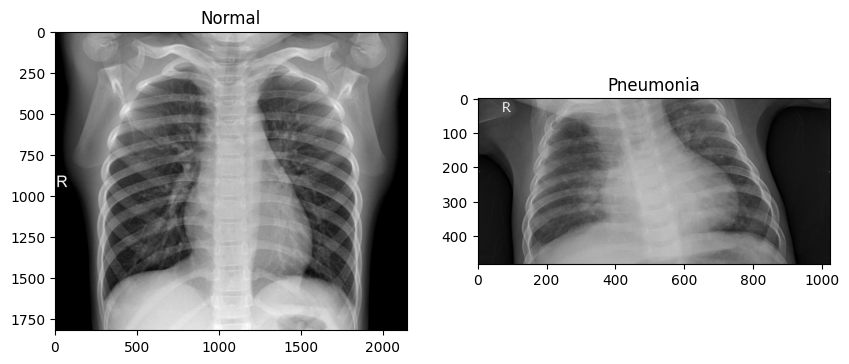

In [7]:
# Both cases are shown in order to observe the differences clearly
train_n = '/content/drive/MyDrive/chest_xray/train/NORMAL/'
train_p = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/'

# Normal pic
rand_norm = np.random.randint(0, len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
norm_pic_address = train_n + norm_pic

# Pneumonia pic
rand_p = np.random.randint(0, len(os.listdir(train_p)))
sic_pic = os.listdir(train_p)[rand_p]
sic_address = train_p + sic_pic

# Load the images and convert to grayscale
norm_load = Image.open(norm_pic_address).convert('L')
sic_load = Image.open(sic_address).convert('L')

# Plot the images
f = plt.figure(figsize=(10, 6))
a1 = f.add_subplot(1, 2, 1)
img_plot = plt.imshow(norm_load, cmap='gray')
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap='gray')
a2.set_title('Pneumonia')

plt.show()

In [8]:
# Data is loaded and formatted to make sure it fits the CNN
def random_rotation_angle():
    return random.randint(0, 360)

def load_images(path, label):
    images = []
    labels = []
    for img_path in glob.glob(path + '/*.jpeg'):
        img = Image.open(img_path).convert('L').resize((64, 64))
        rotation_angle = random_rotation_angle()
        rotated_img = img.rotate(rotation_angle)
        img_array = np.array(rotated_img) / 255.0
        images.append(img_array)
        labels.append(label)
    return images, labels

train_n = '/content/drive/MyDrive/chest_xray/train/NORMAL/'
train_p = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/'

normal_images, normal_labels = load_images(train_n, 0)
pneumonia_images, pneumonia_labels = load_images(train_p, 1)

images = normal_images + pneumonia_images
labels = normal_labels + pneumonia_labels

images = np.array(images)
labels = np.array(labels)
images = images.reshape(-1, 64, 64, 1)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
# CNN is developed for this problem in particular
model = tf.keras.models.Sequential()

# First layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Second layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Third layer
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Fourth layer
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Flatten and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5)) # Add dropout layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5)) # Add dropout layer
model.add(layers.Dense(2, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [10]:
# This callback function serves to end training if desired accuracy is reached
'''
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.97):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True
'''

'\nclass myCallback(tf.keras.callbacks.Callback):\n  def on_epoch_end(self, epoch, logs={}):\n    if(logs.get(\'accuracy\') >= 0.97):\n      print("\nReached 97% accuracy so cancelling training!")\n      self.model.stop_training = True\n'

In [11]:
# We import the callback class to instantiate the callback function
#callbacks = myCallback()

# The model is compiled in order to start training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )
# The data is fitted to the model and training starts
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
131/131 [==============================] - 60s 439ms/step - loss: 0.5962 - accuracy: 0.7453 - val_loss: 0.5954 - val_accuracy: 0.7230
Epoch 2/100
131/131 [==============================] - 57s 436ms/step - loss: 0.5780 - accuracy: 0.7470 - val_loss: 0.5874 - val_accuracy: 0.7230
Epoch 3/100
131/131 [==============================] - 55s 417ms/step - loss: 0.5067 - accuracy: 0.7589 - val_loss: 0.4068 - val_accuracy: 0.7698
Epoch 4/100
131/131 [==============================] - 55s 421ms/step - loss: 0.3768 - accuracy: 0.8253 - val_loss: 0.4352 - val_accuracy: 0.7947
Epoch 5/100
131/131 [==============================] - 61s 464ms/step - loss: 0.3406 - accuracy: 0.8514 - val_loss: 0.3302 - val_accuracy: 0.8415
Epoch 6/100
131/131 [==============================] - 59s 449ms/step - loss: 0.3172 - accuracy: 0.8602 - val_loss: 0.3264 - val_accuracy: 0.8615
Epoch 7/100
131/131 [==============================] - 56s 426ms/step - loss: 0.2862 - accuracy: 0.8731 - val_loss: 0.2882 -

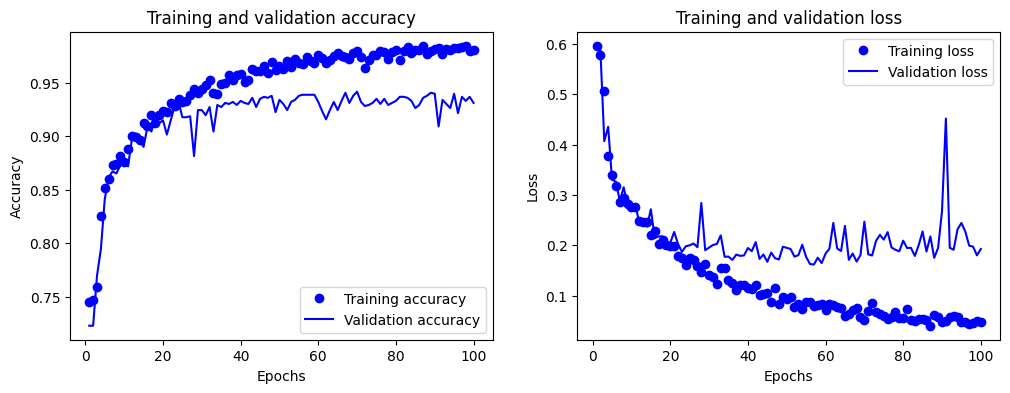

In [12]:
# Function to plot the model's loss and accuracy history to follow patterns that may be useful for insights
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [13]:
# Now we evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

33/33 - 3s - loss: 0.1928 - accuracy: 0.9312 - 3s/epoch - 78ms/step
Test accuracy: 0.9312320947647095


In [14]:
# Finally, we can make predictions with our model
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

33/33 [==============================] - 5s 133ms/step


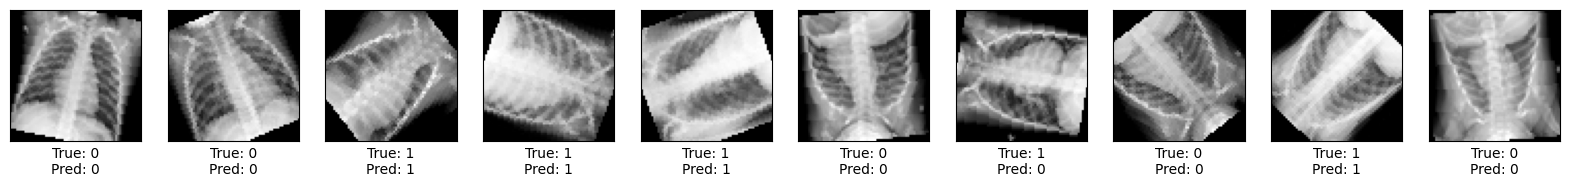

In [15]:
# This function plots the results graphically
def display_predictions(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(num_images * 2, 3))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')

    plt.show()

# We present the results by plotting them
display_predictions(X_test, y_test, predicted_labels)